## EY Datawave Challenge Code

**Simple rule**: 
- all "df_xx" types are pd.DataFrame
- "xx_data" are usually NumPy arrays

# What is in this Version:

Before, we have been predicting by considering all the trajectories separately. Yet, this approach may be misleading in that our goal is to predict **each person's position between 15:00 ~ 16:00 PM, not other time period.** So, it may be better to group trajectories of the same person into one row.

What I used for feature here:

1. Total time elapsed
2. distance from park center (last point)
3. within the park center (last trajectories' entry)
4. within the park center (overall trajectories' exit)
5. Average Velocity
6. Average Bearing (maybe deviation angle from the straight line from starting point to park center?)
7. velocity of last trajectory


In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, model_selection
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import math
import tensorflow.keras.preprocessing.sequence as sequence

from data_prep import read_data, calculate_initial_compass_bearing, feature_extract, make_label

# pd.set_option('display.max_columns', None)

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# global variable: data path
DATA_PATH = "data"

# Read the Data

df is training data + label

In [6]:
#read data
df_train = read_data(DATA_PATH, mode="train")
df_test = read_data(DATA_PATH, mode="test")

## Some look at the data

In [8]:
#debugging
display(df_train.info())
display(df_test.info())
display(df_test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814262 entries, 0 to 814261
Data columns (total 13 columns):
hash                  814262 non-null object
trajectory_id         814262 non-null object
time_entry            814262 non-null object
time_exit             814262 non-null object
vmax                  814262 non-null object
vmin                  814262 non-null object
vmean                 814262 non-null object
x_entry               814262 non-null float64
y_entry               814262 non-null float64
x_exit                814262 non-null float64
y_exit                814262 non-null float64
time_entry_seconds    814262 non-null float64
time_exit_seconds     814262 non-null float64
dtypes: float64(6), object(7)
memory usage: 80.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202937 entries, 0 to 202936
Data columns (total 13 columns):
hash                  202937 non-null object
trajectory_id         202937 non-null object
time_entry            202937 non-null object
time_exit             202937 non-null object
vmax                  202937 non-null object
vmin                  202937 non-null object
vmean                 202937 non-null object
x_entry               202937 non-null float64
y_entry               202937 non-null float64
x_exit                202937 non-null object
y_exit                202937 non-null object
time_entry_seconds    202937 non-null float64
time_exit_seconds     202937 non-null float64
dtypes: float64(4), object(9)
memory usage: 20.1+ MB


None

,x_entry,y_entry,time_entry_seconds,time_exit_seconds
count,2.029370e+05,2.029370e+05,202937.000000,202937.000000
mean,3.760384e+06,-1.922144e+07,39319.951315,39667.776936
std,8.976732e+03,7.670937e+04,14019.192111,14048.608113
min,3.741032e+06,-1.937675e+07,0.000000,0.000000
25%,3.755199e+06,-1.927516e+07,30577.000000,31004.000000
50%,3.760110e+06,-1.923015e+07,42250.000000,42582.000000
75%,3.767453e+06,-1.916959e+07,51190.000000,51545.000000
max,3.776975e+06,-1.904574e+07,57600.000000,57600.000000


In [11]:
a = feature_extract(df_train, single=False)

last = a.groupby('hash', as_index=False).last()

## -----------------------------------------------------------------------

In [12]:
#vmean,x_entry,y_entry,x_exit,time_entry_seconds,time_exit_seconds,total_time,entry_inside,distance_from_center	distance_2,bearing_center,bearing,bearing_diff,travelled-dist

target_x = (a['x_exit']>=3750901.5068) & (a['x_exit']<=3770901.5068)
target_y = (a['y_exit']>=-19268905.6133) & (a['y_exit']<=-19208905.6133)

train_label = 1*(target_x & target_y)
a['train_label'] = train_label.values

one = a[a['train_label']!=0]
zero = a[a['train_label']!=1]

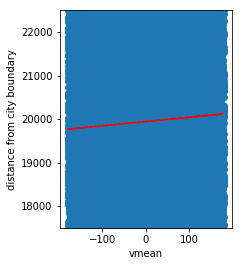

In [13]:
# fig = plt.figure(0)
# ax = fig.add_subplot(122)
# ax.hist(one['bearing'], bins=100)
# ax2 = fig.add_subplot(222)
# ax2.hist(zero['bearing'], bins = 100)

# plt.figure(1)
# plt.hist(one['bearing_center'], bins = 100)
# plt.figure(4)
# plt.hist(zero['bearing_center'], bins =100)

# plt.figure(2)
# plt.hist(abs(one['bearing_diff']), bins = 100)
# plt.figure(5)
# plt.hist(zero['bearing_diff'], bins = 100)





plt.figure(3)
plt.scatter(x=one['bearing_diff'],y=one['distance_from_center'])
z = np.polyfit(one['bearing_diff'], one['distance_from_center'], 1)
p = np.poly1d(z)
plt.plot(one['bearing_diff'],p(one['bearing_diff']),"r--")
plt.xlabel('vmean')
plt.ylabel('distance from city boundary')
# plt.xlim(-50,50)
plt.ylim(17500,22500)
plt.gca().set_aspect(0.1)

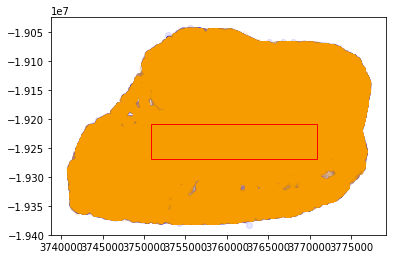

In [14]:
# plt.figure(2)
# dc = a[a['distance_2']!=0]

# v = a[a['vmean']!=0]
# plt.hist(v['vmean'],range = (0,1))

# plt.figure(3)
# plt.scatter(x=v['vmean'],y=v['distance_2'])

# z = np.polyfit(v['vmean'], v['distance_2'], 1)
# p = np.poly1d(z)
# plt.plot(v['vmean'],p(v['vmean']),"r--")
# plt.xlabel('vmean')
# plt.ylabel('distance from city boundary')
# plt.xlim(0,1000)
# # plt.ylim(0,500)

plt.scatter(x=a['x_entry'],y=a['y_entry'], color = 'blue', alpha= 0.1)
plt.scatter(x=a['x_exit'],y=a['y_exit'], color= 'orange', alpha = 0.1)
# plt.axes().set_aspect('equal', 'datalim')

import matplotlib.patches as patches

rect = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
plt.gca().add_patch(rect)

plt.savefig('city center and entry and exit points.png')

plt.show()

## -----------------------------------------------------------------

# Prepare Bearing Dataset

In [12]:
#prepare bearing data and target

bearing_train = a
bearing_target = last

single_bearing = bearing_train.groupby('hash', as_index = False).count()
single_bearing = single_bearing[single_bearing['bearing']==1]
single_bearing = bearing_target.loc[single_bearing.index]

#single+everything row except last traj
bearing_train = bearing_train.merge(bearing_target, how='left', indicator=True)

bearing_train = bearing_train[(bearing_train['_merge']=='left_only')]

zero = single_bearing
zero['entry_inside'] = 0
zero['bearing']=0
zero['bearing_center'] = 0
zero['bearing_diff'] = 0

bearing_train = bearing_train.append(zero, sort=True)

# bearing_train.sort_index(inplace=True)

bearing_train = bearing_train.loc[:,['hash','entry_inside','bearing','bearing_center', 'bearing_diff']]
bearing_target = bearing_target['bearing']

In [13]:
#normalize
bearing_train_data = bearing_train.values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(bearing_train_data[:,[2,3,4]])

bearing_train_data = np.concatenate((bearing_train_data[:,[0,1]],normalized_col), axis = 1)

df_bearing_train_data = pd.DataFrame(bearing_train_data)

df_bearing_train_data.columns = ['hash','entry_inside','bearing','bearing_center', 'bearing_diff']

#Flatten
cc = df_bearing_train_data.groupby('hash').cumcount() + 1
df_bearing_train_data = df_bearing_train_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_bearing_train_data.columns = ['_'.join(map(str,i)) for i in df_bearing_train_data.columns]
df_bearing_train_data.reset_index()

df_bearing_train_data.fillna(0, inplace = True)

df_bearing_train_data['target'] = bearing_target

bearing_train_data=df_bearing_train_data[(df_bearing_train_data['target']!=0)]
bearing_train_data.drop('target', axis=1, inplace=True)
bearing_target = bearing_target.values

#Add the last trajectory's two properties
bearing_train_data['entry_inside'] = last['entry_inside'].values
bearing_train_data['zero_pedding_1'] = 0
bearing_train_data['bearing_center'] = last['bearing_center'].values
bearing_train_data['zero_pedding_2'] = 0

display(bearing_train_data.describe())
display(last.describe())

bearing_train_data = bearing_train_data.values

#reshape
bearing_train_data = bearing_train_data.reshape(134063, 20, 4)

/Users/synch/anaconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,entry_inside_19,bearing_diff_19,bearing_center_19,bearing_19,entry_inside_18,bearing_diff_18,bearing_center_18,bearing_18,entry_inside_17,bearing_diff_17,...,bearing_center_2,bearing_2,entry_inside_1,bearing_diff_1,bearing_center_1,bearing_1,entry_inside,zero_pedding_1,bearing_center,zero_pedding_2
count,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,...,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.0,134063.000000,134063.0
mean,0.000410,0.000617,0.000586,0.000275,0.001261,0.001858,0.001865,0.001047,0.002745,0.003691,...,0.473441,0.200494,0.198720,0.500263,0.493284,0.249361,0.286798,0.0,179.457948,0.0
std,0.020251,0.020594,0.019565,0.013597,0.035483,0.035192,0.034819,0.027000,0.052321,0.048966,...,0.294867,0.308383,0.399038,0.282190,0.282460,0.326540,0.452268,0.0,100.965022,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000039,0.000000,0.000000,0.000000,0.0,0.002843,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.214598,0.000000,0.000000,0.252658,0.241296,0.000000,0.000000,0.0,88.807526,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.459156,0.000000,0.000000,0.499997,0.487656,0.000000,0.000000,0.0,178.888568,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.738993,0.403005,0.000000,0.747622,0.746244,0.499841,1.000000,0.0,269.819040,0.0
max,1.000000,0.998306,0.960620,0.992741,1.000000,0.995532,0.990464,0.996290,1.000000,0.998859,...,0.999995,0.999985,1.000000,1.000000,1.000000,0.999997,1.000000,0.0,359.960845,0.0


,vmean,x_entry,y_entry,x_exit,y_exit,time_entry_seconds,time_exit_seconds,total_time,entry_inside,distance_from_center,distance_2,bearing_center,bearing,bearing_diff,travelled-dist
count,134063.000000,1.340630e+05,1.340630e+05,1.340630e+05,1.340630e+05,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000,134063.000000
mean,24.104959,3.760462e+06,-1.922199e+07,3.760444e+06,-1.922152e+07,55108.091009,55523.096156,415.005147,0.286798,62309.856265,37560.934788,179.457948,89.647144,-0.273112,15874.019958
std,177.805950,9.139148e+03,7.616259e+04,9.245823e+03,7.832898e+04,1202.592938,1020.170634,700.589216,0.452268,47834.881849,42223.917264,100.965022,117.544270,102.400946,37415.432446
min,0.000000,3.741032e+06,-1.937673e+07,3.741027e+06,-1.937675e+07,38005.000000,54000.000000,0.000000,0.000000,104.246457,0.000000,0.002843,0.000000,-179.997676,0.000000
25%,0.000000,3.755138e+06,-1.927616e+07,3.754755e+06,-1.927826e+07,54278.000000,54631.000000,0.000000,0.000000,21019.319520,0.000000,88.807526,0.000000,-90.746444,0.000000
50%,0.000000,3.760182e+06,-1.923025e+07,3.760133e+06,-1.923002e+07,54991.000000,55384.000000,1.000000,0.000000,50825.726011,19963.096659,178.888568,0.000000,-0.255512,0.000000
75%,18.416655,3.767692e+06,-1.917160e+07,3.767767e+06,-1.916722e+07,55989.000000,56346.000000,594.000000,1.000000,96267.720513,65767.421498,269.819040,179.822570,90.158675,10511.766875
max,35330.182048,3.777099e+06,-1.904694e+07,3.777048e+06,-1.904668e+07,57600.000000,57600.000000,19140.000000,1.000000,192032.134746,161960.898405,359.960845,359.999677,179.998983,320346.373937


# Prepare Vmean Data set

In [14]:
#prepare vmean data and target

vmean_train = a
vmean_target = last

single_vmean = vmean_train.groupby('hash', as_index = False).count()
single_vmean = single_vmean[single_vmean['vmean']==1]
single_vmean = vmean_target.loc[single_vmean.index]

#single+everything row except last traj
vmean_train = vmean_train.merge(vmean_target, how='left', indicator=True)

vmean_train = vmean_train[(vmean_train['_merge']=='left_only')]

zero = single_vmean
zero['entry_inside'] = 0
zero['total_time']=0
zero['distance_from_center'] = 0
zero['distance_2'] = 0
zero['bearing_center'] = 0
zero['vmean']=0
zero['travelled-dist'] = 0
vmean_train = vmean_train.append(zero, sort=True)

# bearing_train.sort_index(inplace=True)

vmean_train = vmean_train.loc[:,['hash','entry_inside','total_time',
                                     'distance_from_center', 'distance_2', 
                                     'bearing_center', 'vmean', 'travelled-dist']]
vmean_target = vmean_target['vmean']

In [15]:
#normalize
vmean_train_data = vmean_train.values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(vmean_train_data[:,[2,3,4,5,6,7]])

vmean_train_data = np.concatenate((vmean_train_data[:,[0,1]],normalized_col), axis = 1)

df_vmean_train_data = pd.DataFrame(vmean_train_data)

df_vmean_train_data.columns = ['hash','entry_inside','total_time',
                                     'distance_from_center', 'distance_2', 
                                     'bearing_center', 'vmean', 'travelled-dist']

#Flatten
cc = df_vmean_train_data.groupby('hash').cumcount() + 1
df_vmean_train_data = df_vmean_train_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_vmean_train_data.columns = ['_'.join(map(str,i)) for i in df_vmean_train_data.columns]
df_vmean_train_data.reset_index()

df_vmean_train_data.fillna(0, inplace = True)

df_vmean_train_data['target'] = vmean_target

vmean_train_data=df_vmean_train_data[(df_vmean_train_data['target']!=0)]
vmean_train_data.drop('target', axis=1, inplace=True)
vmean_target = vmean_target.values

#Add the last trajectory's properties
vmean_train_data['zero_pedding_vmean'] = 0
vmean_train_data['zero_pedding_travelled_dist'] = 0
vmean_train_data['total_time'] = last['total_time'].values
vmean_train_data['entry_inside'] = last['entry_inside'].values
vmean_train_data['distance_from_center'] = last['distance_from_center'].values
vmean_train_data['distance_2'] = last['distance_2'].values
vmean_train_data['bearing_center'] = last['bearing_center'].values

display(vmean_train_data.head())
vmean_train_data = vmean_train_data.values

#reshape
vmean_train_data = vmean_train_data.reshape(134063, 20, 7)

,vmean_19,travelled-dist_19,total_time_19,entry_inside_19,distance_from_center_19,distance_2_19,bearing_center_19,vmean_18,travelled-dist_18,total_time_18,...,distance_from_center_1,distance_2_1,bearing_center_1,zero_pedding_vmean,zero_pedding_travelled_dist,total_time,entry_inside,distance_from_center,distance_2,bearing_center
hash,,,,,,,,,,,,,,,,,,,,,
0000a8602cf2def930488dee7cdad104_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.739918,0.691282,0.123379,0,0,962.0,0,45797.982227,14234.591990,75.436891
0000cf177130469eeac79f67b6bcf3df_9,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.145410,0.008733,0.806025,0,0,1756.0,0,29603.985176,1813.564585,56.520045
0001f97b99a80f18f62e2d44e54ef33d_3,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.688586,0.630216,0.870750,0,0,2716.0,0,137051.659155,107034.585072,237.183889
0002124248b0ca510dea42824723ccac_31,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.340245,0.220368,0.859153,0,0,0.0,0,61336.955341,30940.232815,285.070287
000219c2a6380c307e8bffd85b5e404b_23,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054698,0.000000,0.237492,0,0,0.0,0,17851.785279,3260.717965,244.132647


# Prepare all train data set

In [16]:
#normalize
a = a.loc[:,['hash','entry_inside','total_time','distance_from_center',
             'distance_2','bearing','bearing_center','bearing_diff','vmean']]
train_data = a.values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(train_data[:,[2,3,4,5,6,7,8]])

train_data = np.concatenate((train_data[:,[0,1]],normalized_col), axis = 1)

df_train_data = pd.DataFrame(train_data)

df_train_data.columns = ['hash','entry_inside','total_time','distance_from_center',
                         'distance_2','bearing','bearing_center','bearing_diff','vmean']

#Flatten
cc = df_train_data.groupby('hash').cumcount() + 1
df_train_data = df_train_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_train_data.columns = ['_'.join(map(str,i)) for i in df_train_data.columns]
df_train_data.reset_index()

df_train_data.fillna(0, inplace = True)

train_data = df_train_data.values

#make label
df_train_data, train_label = make_label(df_train_data, last)

#reshape
train_data = train_data.reshape(134063, 20,8)


# Keras Regression model for bearing /vmean

In [ ]:
#define model
def regress_model(train_data, train_label, epoch=2, lr=0.001, verbose=1, dropout=0.1):
    
    model = keras.Sequential()
    
    model.add(keras.layers.LSTM(64))
    
    #model.add(keras.layers.Dropout(dropout))

   
    # then we finish again with completely standard Keras way
    model.add(keras.layers.Dense(1))

    #complile the model
    model.compile(optimizer=keras.optimizers.Adam(lr = lr),
                  loss='mean_squared_logarithmic_error',
                  metrics=['mean_squared_error']) 

    #fit the model
    history = model.fit(train_data, train_label, epochs=epoch, batch_size=20,
                         validation_split=0.1, verbose=verbose)

    return history, model

In [ ]:
bearing_history, bearing_model = regress_model(bearing_train_data, bearing_target, epoch=10)

In [ ]:
#Saving bearing model
# bearing_model.save('bearing_model_epoch10.h5')

In [ ]:
vmean_history, vmean_model = regress_model(vmean_train_data, vmean_target, epoch=10)

# Split train/val for all train dataset

In [ ]:
train_data, val_data, train_label, val_label = model_selection.train_test_split(
                                                    train_data,train_label,test_size = 0.2)

# Keras NN model - LSTM

binary softmax, but categorical_crossentropy loss. *can improve loss, optimizer, layer*

In [ ]:
#define model
def EY_model(train_data, train_label, val_data, val_label, 
             epoch=2, lr=0.001, verbose=0, dropout=0.1):
    
    model = keras.Sequential()
    
    model.add(keras.layers.LSTM(64,
                    activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))

   
    # then we finish again with completely standard Keras way
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    #complile the model
    model.compile(optimizer=keras.optimizers.Adam(lr = lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 

    #fit the model
    f1 = F1((val_data, val_label))
    history = model.fit(train_data, train_label, epochs=epoch, batch_size=20,
                        validation_data=(val_data, val_label), callbacks=[reach_90acc, f1], 
                        verbose=verbose)

    return f1, history, model

In [ ]:
f1, history, model = EY_model(train_data, train_label, val_data, val_label, epoch = 25, lr=0.0005, verbose=1)

In [ ]:
#Saving bearing model
# model.save('model_epoch20.h5')

# Prepare the Test Data

choose the features: 

*velocty for pred data is weired

Change the time values into float, by dividing into minutes.

Finally, store test_data_pred and test_data_eval as NumPy arrays, and normalize them.

# Prepare bearing Data set

In [ ]:
#prepare bearing data and target

bearing_test = df_test
bearing_test['index'] = bearing_test.index

last_test = bearing_test.groupby('hash', as_index=False).last()
last_test.index = last_test['index']

single_bearing = bearing_test.groupby('hash', as_index = False).agg(
    {
         'trajectory_id':"count",    
         'index': "first",  
    }
)
single_bearing.index = single_bearing['index']
single_bearing = single_bearing[single_bearing['trajectory_id']==1]

single_bearing = last_test.loc[single_bearing.index]

bearing_test.drop('index', axis=1, inplace=True)
last_test.drop('index', axis=1, inplace=True)
single_bearing.drop('index', axis=1, inplace=True)

single_bearing = feature_extract(single_bearing, single=True)

single_bearing['bearing'] = 0
single_bearing['vmean'] = 0
single_bearing['travelled-dist'] = 0

bearing_test = bearing_test.merge(last_test, how='left', indicator=True)

bearing_test = bearing_test[(bearing_test['_merge']=='left_only')]

#Conversion to avoid runtime error
bearing_test.x_exit = bearing_test.x_exit.astype('float64')
bearing_test.y_exit = bearing_test.y_exit.astype('float64')

bearing_test = feature_extract(bearing_test, single=False)
bearing_test.drop('_merge', axis=1, inplace=True)

# #Calculate vmean average for all non-last trajectories
# vmean_single = bearing_test['vmean'].mean()

display(bearing_test.describe())

#Single_bearing to be zero and append to the bearing_test
zero = single_bearing
#######################################################
zero['entry_inside'] = 0
zero['total_time']=0
zero['distance_from_center'] = 0
zero['distance_2'] = 0
zero['bearing_center'] = 0
zero['bearing_diff'] = 0
# zero['vmean']=0
# zero['travelled-dist'] = 0
# zero['bearing']=0
bearing_test = bearing_test.append(zero)

bearing_test.sort_index(inplace=True)

In [ ]:
#Normalize
bearing_test_data = bearing_test.loc[:,['hash','entry_inside','bearing_center',
                                        'bearing','bearing_diff']].values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(bearing_test_data[:,[2,3,4]])

bearing_test_data = np.concatenate((bearing_test_data[:,[0,1]],normalized_col), axis = 1)

df_bearing_test_data = pd.DataFrame(bearing_test_data)

df_bearing_test_data.columns = ['hash','entry_inside','bearing_center',
                                'bearing','bearing_diff']


#Flatten
cc = df_bearing_test_data.groupby('hash').cumcount() + 1
df_bearing_test_data = df_bearing_test_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_bearing_test_data.columns = ['_'.join(map(str,i)) for i in df_bearing_test_data.columns]
df_bearing_test_data.reset_index()

df_bearing_test_data.fillna(0, inplace = True)
last_test = feature_extract (last_test, single=True)

#Add the last trajectory's two properties
df_bearing_test_data['entry_inside'] = last_test['entry_inside'].values
df_bearing_test_data['zero_pedding_1'] = 0
df_bearing_test_data['bearing_center'] = last_test['bearing_center'].values
df_bearing_test_data['zero_pedding_2'] = 0



display(df_bearing_test_data.describe())
display(last_test.describe())

bearing_test_data = df_bearing_test_data.values

#reshape
bearing_test_data = bearing_test_data.reshape(33515, 20, 4)


In [ ]:
bearing_predict = bearing_model.predict(bearing_test_data)


last_test['bearing'] = bearing_predict
last_test['bearing_diff'] = last_test['bearing_center'] - \
                                    last_test['bearing']

last_test.loc[last_test.bearing_diff > 180, 'bearing_diff'] = \
                                -360 + last_test.bearing_diff

last_test.loc[last_test.bearing_diff < -180, 'bearing_diff'] = \
                                360 + last_test.bearing_diff


# Prepare Vmean Dataset

In [ ]:
#Normalize
vmean_test_data = bearing_test.loc[:,['hash','entry_inside','total_time',
                                     'distance_from_center', 'distance_2', 
                                     'bearing_center', 'vmean', 'travelled-dist']].values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(vmean_test_data[:,[2,3,4,5,6,7]])

vmean_test_data = np.concatenate((vmean_test_data[:,[0,1]],normalized_col), axis = 1)

df_vmean_test_data = pd.DataFrame(vmean_test_data)

df_vmean_test_data.columns = ['hash','entry_inside','total_time',
                                     'distance_from_center', 'distance_2', 
                                     'bearing_center', 'vmean', 'travelled-dist']


#Flatten
cc = df_vmean_test_data.groupby('hash').cumcount() + 1
df_vmean_test_data = df_vmean_test_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_vmean_test_data.columns = ['_'.join(map(str,i)) for i in df_vmean_test_data.columns]
df_vmean_test_data.reset_index()

df_vmean_test_data.fillna(0, inplace = True)

#Add the last trajectory's two properties
df_vmean_test_data['zero_pedding_vmean'] = 0
df_vmean_test_data['zero_pedding_travelled_dist'] = 0
df_vmean_test_data['total_time'] = last_test['total_time'].values
df_vmean_test_data['entry_inside'] = last_test['entry_inside'].values
df_vmean_test_data['distance_from_center'] = last_test['distance_from_center'].values
df_vmean_test_data['distance_2'] = last_test['distance_2'].values
df_vmean_test_data['bearing_center'] = last_test['bearing_center'].values


display(df_vmean_test_data.describe())

vmean_test_data = df_vmean_test_data.values

#reshape
vmean_test_data = vmean_test_data.reshape(33515, 20, 7)



In [ ]:
vmean_predict = vmean_model.predict(vmean_test_data)

last_test['vmean'] = vmean_predict

In [ ]:
#Appending last-trajectory
x = bearing_test.merge(single_bearing, how='left', indicator=True).set_index(bearing_test.index)
x = x[(x['_merge']=='left_only')]
x = x.append(last_test)
x.sort_index(inplace=True)

bearing_test = x

# Prepare Pred data set - other than bearing / vmean

In [ ]:
#for others
bearing_test = bearing_test.loc[:,['hash','entry_inside','total_time','distance_from_center',
                                   'distance_2','bearing','bearing_center','bearing_diff','vmean']]

test_data = bearing_test.values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(test_data[:,[2,3,4,5,6,7,8]])

test_data = np.concatenate((test_data[:,[0,1]],normalized_col), axis = 1)

df_test_data = pd.DataFrame(test_data)

df_test_data.columns = ['hash','entry_inside','total_time','distance_from_center',
                        'distance_2','bearing','bearing_center','bearing_diff','vmean']

cc = df_test_data.groupby('hash').cumcount() + 1
df_test_data = df_test_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_test_data.columns = ['_'.join(map(str,i)) for i in df_test_data.columns]
df_test_data.reset_index()

df_test_data.fillna(0, inplace = True)

test_data = df_test_data.values

test_data = test_data.reshape(33515, 20,8)

# Predict the Data

Predict the test_data_pred and if the p(xi) is over 0.5, save it as 1, otherwise 0. Predictions is the NumPy array saving the result. Formulate pd.DataFrame from df_testPred['trajectory_id'] and predictions ('target') so that the output DataFrame is in ['id', 'target'] format.

In [ ]:
###################prediction for Single Traj#######################
predictions = model.predict(test_data)

predictions = (predictions >= 0.5) *1

last_test = df_test.groupby('hash').last()
t_id = pd.DataFrame(last_test['trajectory_id'])

target = pd.DataFrame(predictions)
target.columns = ['target']

output = pd.concat([t_id.reset_index(drop=True),target.reset_index(drop=True)], axis=1)
output.columns = ['id', 'target']


####################append single and multi########################


output.to_csv("Time_series_vmean+bearing_edits.csv", index=False)

display(output)

# Evaluation of the Models

print the summary and test accuracy

In [ ]:
#evaluate the accuracy of the model
model.summary()


val_loss, val_acc = model.evaluate(val_data, val_label)

print('val accuracy of Multi Traj Model:', val_acc)

# Plot the model's Learning Curve

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [ ]:
# summarize history for acc
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for f1, recall, precision
plt.plot(f1.val_f1s)
plt.plot(f1.val_recalls)
plt.plot(f1.val_precisions)
plt.title('f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['f1', 'recall','precision'], loc='upper left')
plt.show()

##################bearing#########################
# summarize history for acc
plt.plot(bearing_history.history['mean_squared_error'])
plt.plot(bearing_history.history['val_mean_squared_error'])
plt.title('bearing error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(bearing_history.history['loss'])
plt.plot(bearing_history.history['val_loss'])
plt.title('bearing loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(vmean_history.history['mean_squared_error'])
plt.plot(vmean_history.history['val_mean_squared_error'])
plt.title('bearing error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(vmean_history.history['loss'])
plt.plot(vmean_history.history['val_loss'])
plt.title('bearing loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()